# Import Requirements

In [2]:

%load_ext autoreload

%autoreload 2   

%matplotlib notebook

import os
import os.path as osp
import sys 
import time



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from architectures.ssd_feature_fused_deconv_eltsum import build_ssd

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision as tv
import torch.optim as optim



In [5]:
import torch.utils.data as data
import torchvision.datasets

import numpy as np
from PIL import Image
import argparse

from matplotlib import pyplot as plt
import pandas as pd
import cv2 
import pickle as pkl
import random
import tarfile
import collections
import math
import datetime
import pickle


# Settings   

In [14]:

from config_vgg16_ssd import *
import xml.etree.ElementTree as ET

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [43]:

def xavier(param):
    nn.init.xavier_uniform(param)


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()


In [15]:
def plot(list_loss , fig, axes ):

    
    axes.clear()
    axes.set_title('plot loss')
    
    axes.plot(list_loss, label='training loss')
    axes.set_ylabel('Loss')
    axes.set_xlabel('iter') 
    axes.legend()
    
    
    plt.tight_layout()
    fig.canvas.draw()


In [32]:

def train(device, resume=None, num_iters=60000):
    
    #use voc config 
    
   
    cfg = voc
 
    ssd_net = build_ssd('train', cfg['min_dim'], cfg['num_classes'])
    dataset = VOCDetection(root=voc_root, 
                            transform=SSDAugmentation(cfg['min_dim'],
                             MEANS))
     
    
    if resume:
        print('Resuming training, loading previous training at ',resume)
        ssd_net.load_weights(resume ) 
        # strict is false if started from ssd pretrained model 
        #ssd_net.load_state_dict(ssd_weights , strict=False)
        #ssd_net.feature_fusion.apply(weights_init)
        
    else:
        vgg_weights = torch.load(basenet)
        print('Loading base network...')
        ssd_net.vgg.load_state_dict(vgg_weights)
        print('Initializing weights...')
        ssd_net.extras.apply(weights_init)
        ssd_net.loc.apply(weights_init)
        ssd_net.conf.apply(weights_init) 
        ssd_net.feature_fusion.apply(weights_init) 
        
    
    net = ssd_net
    
    #print(vgg_weight)
    #for param in net.vgg.parameters() :
    #    print(param.requires_grad)
    
    if device:
        net = torch.nn.DataParallel(ssd_net)
        torch.backends.cudnn.benchmark = True
        net = net.to(device)
        
    optimizer = optim.SGD(net.parameters(), lr, momentum, weight_decay)
    
    criterion = MultiBoxLoss(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,
                             False, torch.cuda.is_available())

    
    net.train()
    mode = 'train'
    
    
    loc_loss = 0
    conf_loss = 0
    epoch = 0
    print('Loading the dataset...')

    epoch_size = len(dataset) // batch_size
    print('Training SSD on: ',mode)

    step_index = 0

    #based on adapted code
    train_data_loader = data.DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=True,\
                               collate_fn=detection_collate,pin_memory=True)
    
    print("Images in the training set = " + str(len(dataset)))
    print("Images in a mini-batch = "+str(batch_size))
    print("mini-batches = " + str(len(train_data_loader)))
    
    
     # create batch iterator
    batch_iterator = iter(train_data_loader)
    print("STARTING - ITERATIONS")
    
    
    l_loss = []
    c_loss = []
    itr = []
    
    with open('trained_weights/vgg16_ssd_stats_SGD_feature_fusion_eltsum.pkl','rb') as f:
        l_loss, c_loss, itr = pickle.load(f)   
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(7, 6))
    
    

    start_itr = len(itr) 
    for iteration in range(start_itr , num_iters) : 
        if iteration != 0 and (iteration % epoch_size == 0):
            # reset epoch loss counters
            loc_loss = 0
            conf_loss = 0
            epoch += 1

        if iteration in cfg['lr_steps']:
            step_index += 1
            lr_dec = lr * (gamma ** (step_index))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_dec
        
            
        ## load train data
        try:
            images, targets = next(batch_iterator)
        except StopIteration:
            batch_iterator = iter(train_data_loader)
            images, targets = next(batch_iterator)


        
        if device:
            images = images.cuda()
            targets = [ann.cuda() for ann in targets]
        else:
            images = images
            targets = [ann for ann in targets]
        
        # forward
        t0 = time.time()
        out = net(images)
    
        # backprop
        optimizer.zero_grad()
    
        loss_l, loss_c = criterion(out, targets)
        loss = loss_l + loss_c
    
        loss.backward()
    
        optimizer.step()
    
        l_loss.append(loss_l.data.item())
        c_loss.append(loss_c.data.item())
        
        t1 = time.time()
        loc_loss += loss_l.data.item()
        conf_loss += loss_c.data.item()
        
        itr.append(iteration)
        
        if iteration % 10 == 0:
            print('timer: %.4f sec.' % (t1 - t0))
            print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.data.item()), end=' ')
            currentDT = datetime.datetime.now()
            print (currentDT.strftime("%H:%M:%S %p"))
            print("\n")
        
        
        if iteration != 0 and iteration % 10 == 0:
            print('Saving state, iter:', iteration)
            iter_name = math.ceil(iteration/100)*100
            if iteration % 100 == 0:
                torch.save(ssd_net.state_dict(), 'trained_weights/ssd_VGG16_VOC_feature_fusion_eltsum' + '.pth') #dump on the same
            with open('trained_weights/vgg16_ssd_stats_SGD_feature_fusion_eltsum.pkl','wb') as f:
                pkl.dump([l_loss, c_loss, itr], f)
            
          
            plot([l_loss[k]+c_loss[k] for k in range(len(l_loss))],fig,axes )
                

    torch.save(ssd_net.state_dict(),
               save_folder + data_set + '.pth') 

### 

In [16]:
!cat config_vgg16_ssd.py

#Initialize pointers
data_set = 'VOC'
dataset_root = '//datasets/home/12/312/vpotnuru/data/VOC0712/VOC2007/'
voc_root = '//datasets/home/12/312/vpotnuru/data/VOC0712/'
save_folder = 'trained_weights/'
eval_save_folder = 'eval/'
devkit_path = 'devkit_path/'
output_dir = "out/"

#Run related metaparameters

batch_size = 32
resume = None

#Optimization metaparameters
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
    
confidence_threshold = 0.01
top_k = 5
cleanup = True

YEAR = '2012'
dataset_mean = (104, 117, 123)
set_type = 'train'

# models to start from , based on he problem 
trained_model = 'weights/ssd_pretrained.pth'
basenet = 'weights/vgg16_reducedfc.pth'


change log in ssd.py
Resuming training, loading previous training at  trained_weights/ssd_VGG16_VOC_feature_fusion_eltsum.pth
Loading weights into state dict...
Finished!
Loading the dataset...
Training SSD on:  train
Images in the training set = 16551
Images in a mini-batch = 32
mini-batches = 518
STARTING - ITERATIONS


<IPython.core.display.Javascript object>


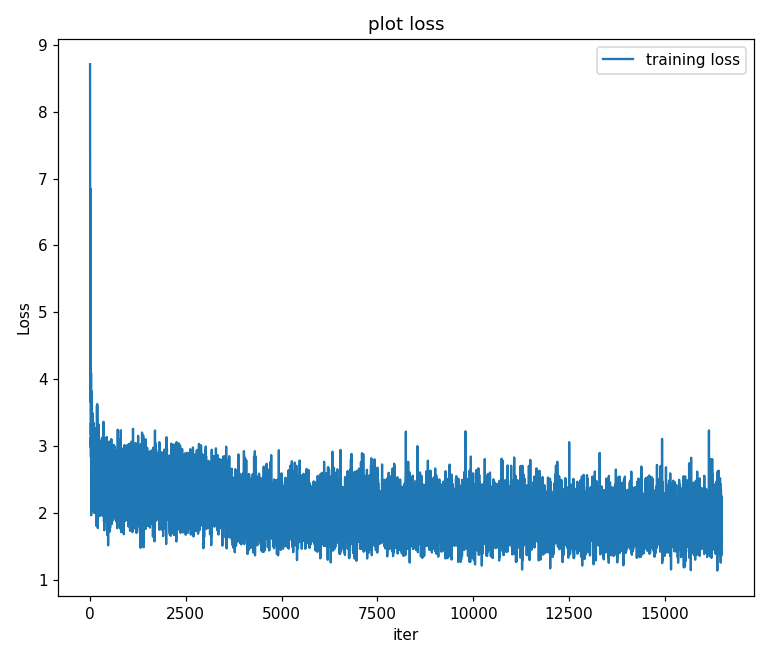

timer: 0.6782 sec.
iter 11500 || Loss: 1.6998 || 18:06:55 PM


Saving state, iter: 11500
timer: 0.7157 sec.
iter 11510 || Loss: 1.8072 || 18:07:05 PM


Saving state, iter: 11510
timer: 0.7102 sec.
iter 11520 || Loss: 2.1090 || 18:07:15 PM


Saving state, iter: 11520
timer: 0.6869 sec.
iter 11530 || Loss: 1.8595 || 18:07:25 PM


Saving state, iter: 11530
timer: 0.7671 sec.
iter 11540 || Loss: 2.0000 || 18:07:36 PM


Saving state, iter: 11540
timer: 0.8809 sec.
iter 11550 || Loss: 1.8277 || 18:07:45 PM


Saving state, iter: 11550
timer: 0.6847 sec.
iter 11560 || Loss: 1.8356 || 18:07:56 PM


Saving state, iter: 11560
timer: 0.7106 sec.
iter 11570 || Loss: 1.8504 || 18:08:06 PM


Saving state, iter: 11570
timer: 0.7062 sec.
iter 11580 || Loss: 2.3252 || 18:08:17 PM


Saving state, iter: 11580
timer: 0.6984 sec.
iter 11590 || Loss: 2.2048 || 18:08:29 PM


Saving state, iter: 11590
timer: 0.5995 sec.
iter 11600 || Loss: 1.4792 || 18:08:40 PM


Saving state, iter: 11600
timer: 0.6869 sec.
it

timer: 0.6960 sec.
iter 12430 || Loss: 1.5933 || 18:22:56 PM


Saving state, iter: 12430
timer: 0.6809 sec.
iter 12440 || Loss: 1.8062 || 18:23:07 PM


Saving state, iter: 12440
timer: 0.7965 sec.
iter 12450 || Loss: 1.8942 || 18:23:17 PM


Saving state, iter: 12450
timer: 0.8122 sec.
iter 12460 || Loss: 2.1123 || 18:23:29 PM


Saving state, iter: 12460
timer: 0.6381 sec.
iter 12470 || Loss: 2.3391 || 18:23:38 PM


Saving state, iter: 12470
timer: 0.6988 sec.
iter 12480 || Loss: 1.3272 || 18:23:50 PM


Saving state, iter: 12480
timer: 0.7119 sec.
iter 12490 || Loss: 1.8492 || 18:24:01 PM


Saving state, iter: 12490
timer: 0.7050 sec.
iter 12500 || Loss: 1.7120 || 18:24:13 PM


Saving state, iter: 12500
timer: 0.6384 sec.
iter 12510 || Loss: 1.8251 || 18:24:20 PM


Saving state, iter: 12510
timer: 0.7152 sec.
iter 12520 || Loss: 1.5949 || 18:24:31 PM


Saving state, iter: 12520
timer: 0.9062 sec.
iter 12530 || Loss: 1.8538 || 18:24:43 PM


Saving state, iter: 12530
timer: 0.6837 sec.
it

timer: 0.6703 sec.
iter 13360 || Loss: 2.0338 || 18:39:03 PM


Saving state, iter: 13360
timer: 0.8356 sec.
iter 13370 || Loss: 1.9937 || 18:39:12 PM


Saving state, iter: 13370
timer: 0.7709 sec.
iter 13380 || Loss: 2.0201 || 18:39:24 PM


Saving state, iter: 13380
timer: 0.7111 sec.
iter 13390 || Loss: 2.1097 || 18:39:33 PM


Saving state, iter: 13390
timer: 0.6980 sec.
iter 13400 || Loss: 1.6606 || 18:39:45 PM


Saving state, iter: 13400
timer: 0.6823 sec.
iter 13410 || Loss: 1.6069 || 18:39:54 PM


Saving state, iter: 13410
timer: 0.6923 sec.
iter 13420 || Loss: 1.5829 || 18:40:06 PM


Saving state, iter: 13420
timer: 0.6957 sec.
iter 13430 || Loss: 2.0205 || 18:40:15 PM


Saving state, iter: 13430
timer: 0.7066 sec.
iter 13440 || Loss: 2.1130 || 18:40:25 PM


Saving state, iter: 13440
timer: 0.5911 sec.
iter 13450 || Loss: 1.8007 || 18:40:36 PM


Saving state, iter: 13450
timer: 0.6806 sec.
iter 13460 || Loss: 2.0406 || 18:40:47 PM


Saving state, iter: 13460
timer: 0.7134 sec.
it

timer: 0.6237 sec.
iter 14290 || Loss: 2.1785 || 18:55:19 PM


Saving state, iter: 14290
timer: 0.7674 sec.
iter 14300 || Loss: 1.8139 || 18:55:28 PM


Saving state, iter: 14300
timer: 0.7938 sec.
iter 14310 || Loss: 1.8538 || 18:55:39 PM


Saving state, iter: 14310
timer: 0.6974 sec.
iter 14320 || Loss: 1.6793 || 18:55:49 PM


Saving state, iter: 14320
timer: 0.6243 sec.
iter 14330 || Loss: 1.9490 || 18:55:59 PM


Saving state, iter: 14330
timer: 0.7135 sec.
iter 14340 || Loss: 1.9412 || 18:56:09 PM


Saving state, iter: 14340
timer: 0.7148 sec.
iter 14350 || Loss: 2.0188 || 18:56:20 PM


Saving state, iter: 14350
timer: 0.6312 sec.
iter 14360 || Loss: 2.0803 || 18:56:31 PM


Saving state, iter: 14360
timer: 0.6981 sec.
iter 14370 || Loss: 1.4543 || 18:56:41 PM


Saving state, iter: 14370
timer: 0.7205 sec.
iter 14380 || Loss: 2.2993 || 18:56:51 PM


Saving state, iter: 14380
timer: 0.6820 sec.
iter 14390 || Loss: 1.9825 || 18:57:02 PM


Saving state, iter: 14390
timer: 0.6041 sec.
it

timer: 0.7253 sec.
iter 15220 || Loss: 2.4794 || 19:13:35 PM


Saving state, iter: 15220
timer: 0.7092 sec.
iter 15230 || Loss: 1.4775 || 19:13:48 PM


Saving state, iter: 15230
timer: 0.8083 sec.
iter 15240 || Loss: 2.1447 || 19:13:59 PM


Saving state, iter: 15240
timer: 0.7151 sec.
iter 15250 || Loss: 2.2220 || 19:14:11 PM


Saving state, iter: 15250
timer: 0.7966 sec.
iter 15260 || Loss: 1.9523 || 19:14:20 PM


Saving state, iter: 15260
timer: 0.8748 sec.
iter 15270 || Loss: 2.0744 || 19:14:32 PM


Saving state, iter: 15270
timer: 0.6729 sec.
iter 15280 || Loss: 1.8363 || 19:14:41 PM


Saving state, iter: 15280
timer: 0.6913 sec.
iter 15290 || Loss: 1.9909 || 19:14:52 PM


Saving state, iter: 15290
timer: 0.7111 sec.
iter 15300 || Loss: 2.4182 || 19:15:03 PM


Saving state, iter: 15300
timer: 0.7228 sec.
iter 15310 || Loss: 1.5892 || 19:15:16 PM


Saving state, iter: 15310
timer: 0.6957 sec.
iter 15320 || Loss: 2.1376 || 19:15:25 PM


Saving state, iter: 15320
timer: 0.7118 sec.
it

timer: 0.5302 sec.
iter 16150 || Loss: 1.7730 || 19:30:39 PM


Saving state, iter: 16150
timer: 0.7691 sec.
iter 16160 || Loss: 1.6858 || 19:30:54 PM


Saving state, iter: 16160
timer: 0.7274 sec.
iter 16170 || Loss: 1.8057 || 19:31:04 PM


Saving state, iter: 16170
timer: 0.7238 sec.
iter 16180 || Loss: 2.0687 || 19:31:15 PM


Saving state, iter: 16180
timer: 0.9018 sec.
iter 16190 || Loss: 1.5786 || 19:31:25 PM


Saving state, iter: 16190
timer: 0.7007 sec.
iter 16200 || Loss: 2.6235 || 19:31:35 PM


Saving state, iter: 16200
timer: 0.7966 sec.
iter 16210 || Loss: 2.1453 || 19:31:47 PM


Saving state, iter: 16210
timer: 0.8068 sec.
iter 16220 || Loss: 2.0134 || 19:31:57 PM


Saving state, iter: 16220
timer: 0.7955 sec.
iter 16230 || Loss: 2.1791 || 19:32:09 PM


Saving state, iter: 16230
timer: 0.8157 sec.
iter 16240 || Loss: 1.6289 || 19:32:18 PM


Saving state, iter: 16240
timer: 0.5743 sec.
iter 16250 || Loss: 1.9383 || 19:32:30 PM


Saving state, iter: 16250
timer: 0.7109 sec.
it

In [34]:

train(device, 'trained_weights/ssd_VGG16_VOC_feature_fusion_eltsum.pth' , num_iters = 16500 )

# Plot 

<IPython.core.display.Javascript object>


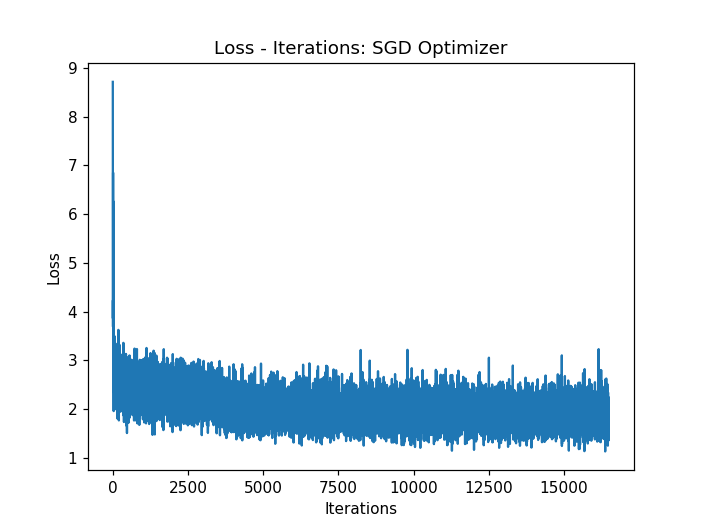

Text(0, 0.5, 'Loss')

In [6]:
with open('trained_weights/vgg16_ssd_stats_SGD_feature_fusion_eltsum.pkl','rb') as f:
    l_loss, c_loss, itr = pickle.load(f)


    

l_loss = np.asarray(l_loss)
c_loss = np.asarray(c_loss)
itr = np.asarray(itr)
plt.plot(itr,l_loss+c_loss)
plt.title('Loss - Iterations: SGD Optimizer')
plt.xlabel('Iterations')
plt.ylabel('Loss')